In [1]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Marker proteins of anatomical regions listed in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [2]:
hpa_markers = pd.read_csv('./data/hpa_markers.csv',index_col=0)
hpa_markers

,region,gene
Ensembl ID(supplied by Ensembl),,
ENSG00000128567,glomerulus,PODXL
ENSG00000158457,glomerulus,TSPAN33
ENSG00000113578,glomerulus,FGF1
ENSG00000116218,glomerulus,NPHS2
ENSG00000198743,glomerulus,SLC5A3
...,...,...
ENSG00000105707,collecting duct,HPN
ENSG00000214128,collecting duct,TMEM213
ENSG00000100362,collecting duct,PVALB


Our manual mapping of cell types in "Single cell transcriptional and chromatin accessibility profiling redefine cellular heterogeneity in the adult human kidney" to anatomical regions in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [3]:
hpa_mapping = pd.Series({
    'epithelial cell of proximal tubule':'proximal tubule',
    'fibroblast':None,
    'glomerular visceral epithelial cell':'glomerulus',
    'kidney capillary endothelial cell':'glomerulus',
    'kidney connecting tubule epithelial cell':'distal tubule',
    'kidney distal convoluted tubule epithelial cell':'distal tubule',
    'kidney loop of Henle thick ascending limb epithelial cell':'distal tubule',
    'leukocyte':None,
    'mesangial cell':'glomerulus',
    'parietal epithelial cell':'glomerulus',
    'renal alpha-intercalated cell':'collecting duct',
    'renal beta-intercalated cell':'collecting duct',
    'renal principal cell':'collecting duct'
},name='region')

Our method's per-image predictions. To permit evaluate we aggregate these first to antibody-level then to gene-level via averaging.

In [4]:
SCORES = 'kidney_scores'

df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)

simclr_scores = pd.read_csv(f'./data/{SCORES}.csv',index_col=0)
simclr_scores = ( simclr_scores.join(df[['Antibody','Gene']])
                               .groupby(['Antibody','Gene']).mean()
                               .groupby('Gene').mean() )
simclr_scores

,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
Gene,,,,,,,,,,,,,
ENSG00000000003,0.076426,0.075838,0.072651,0.074462,0.078169,0.078395,0.085221,0.079109,0.072358,0.075067,0.080887,0.074354,0.077061
ENSG00000000005,0.074836,0.082586,0.078402,0.081068,0.073785,0.073076,0.077786,0.082451,0.078521,0.076873,0.075626,0.071354,0.073636
ENSG00000000419,0.075563,0.078571,0.077975,0.075908,0.077712,0.078627,0.080525,0.073376,0.075066,0.076519,0.078338,0.074327,0.077494
ENSG00000000457,0.072988,0.077093,0.080799,0.081211,0.072261,0.071621,0.079764,0.088608,0.077405,0.078816,0.075197,0.070171,0.074065
ENSG00000000460,0.084942,0.072680,0.074784,0.078337,0.072380,0.071931,0.078617,0.080012,0.077665,0.079658,0.075751,0.076218,0.077022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288607,0.077283,0.074650,0.082576,0.076004,0.070698,0.072675,0.083989,0.087260,0.071725,0.081299,0.077610,0.069337,0.074895
ENSG00000288616,0.077283,0.074650,0.082576,0.076004,0.070698,0.072675,0.083989,0.087260,0.071725,0.081299,0.077610,0.069337,0.074895
ENSG00000288631,0.077283,0.074650,0.082576,0.076004,0.070698,0.072675,0.083989,0.087260,0.071725,0.081299,0.077610,0.069337,0.074895


Simple baseline: one-versus-rest Wilcoxon tests on scRNA.

In [5]:
adata = sc.read('./data/local.h5ad')
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata)
adata = adata[:,list(set(hpa_markers.index)&set(adata.var_names))].copy()

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='wilcoxon',use_raw=False)
wilcoxon_scores = sc.get.rank_genes_groups_df(adata,group=None)
wilcoxon_scores = wilcoxon_scores.pivot(index='names',columns='group',values='scores')

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='t-test',use_raw=False)
ttest_scores = sc.get.rank_genes_groups_df(adata,group=None)
ttest_scores = ttest_scores.pivot(index='names',columns='group',values='scores')
ttest_scores

group,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
names,,,,,,,,,,,,,
ENSG00000004948,-44.733444,-28.791033,-24.355230,-17.853590,-42.611668,29.655279,23.633970,-7.233623,-14.500906,-29.819168,-4.880006,-34.515076,-33.665054
ENSG00000007216,20.833302,-22.103024,-8.559255,-6.797849,-21.330557,-18.621908,-14.667913,-22.101055,-7.903287,-13.724620,-15.527706,-8.364832,-9.745852
ENSG00000008196,-41.162056,-14.920892,-21.081556,-20.165648,-14.665365,8.164674,34.825951,-48.299126,-19.830240,-23.501884,-28.518476,-16.587290,0.132820
ENSG00000010932,30.256937,-31.299704,-16.156851,-9.470925,-20.857422,-24.569416,-25.980495,-2.541900,-6.806368,-7.469543,-20.727667,-7.713006,-15.390405
ENSG00000015413,59.124695,-12.739351,-26.302553,-24.923491,-44.776329,-43.042603,-42.545475,-52.689510,-8.940749,-19.176580,-29.776266,-22.005070,-33.991062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000204653,20.775036,-3.221577,-6.537712,-16.352375,-15.873324,-16.429007,-17.626879,-21.897408,-21.899754,-12.085157,-13.869867,-21.901239,-15.861681
ENSG00000214128,-48.792625,-6.602765,-17.699940,-22.850433,2.566607,24.898836,2.172393,-4.939250,-8.898575,-25.001682,25.069241,13.828671,-7.185124
ENSG00000235961,5.346296,-8.870846,0.718775,-5.068613,0.302918,-5.583587,-3.781314,-8.870720,-8.870874,-2.756822,-0.952535,-8.870972,-0.177415


Run "Comet": https://github.com/MSingerLab/COMETSC.

# TODO

In [6]:
# !mkdir -p ./scratch
# adata[:,list(set(hpa_markers.index)&set(adata.var_names))].to_df().T.to_csv('./scratch/tabmarker.txt',sep='\t')
# !touch tabvis.txt
# adata.obs['cell_type'].reset_index().to_csv('./scratch/tabcluster.txt',sep='\t',index=False,header=False)

# !conda create -y --name comet python==3.6 && source activate comet && python -m pip install COMETSC
# !source activate comet && Comet ./scratch/tabmarker.txt ./scratch/tabvis.txt ./scratch/tabcluster.txt ./scratch/output/ -skipvis True -K 1 -C 32

In [7]:
# comet_scores = {}
# fns = !ls ./output/data/cluster_*_positive_markers_ranked.csv
# for fn in fns:
#     cluster = fn.split('_')[1]
#     comet_scores[cluster] = pd.read_csv(fn,index_col=0)['mHG_stat']
# comet_scores = pd.DataFrame(comet_scores)
# comet_scores

Aggregate per-cell-type scores into per-region scores.

In [8]:
# from src.classifier import platt_scaling

true_regions = hpa_markers.reset_index().pivot(index=hpa_markers.index.name,columns='region')['gene']
true_regions = true_regions.fillna(0).astype(bool).astype(int)

# only compare markers detected in all three
# in principle this shouldn't be an issue: RNA detects ~33k genes, and proteins measured in previous HPA should be present in v21 too
true_regions = true_regions.loc[set(true_regions.index)&set(simclr_scores.index)&set(adata.var_names)]

def aggregate_regions(cell_type_scores, score_type):
    region_scores = cell_type_scores.T.join(hpa_mapping).groupby('region')
    if score_type=='probabilities':
        region_scores = region_scores.sum().T
        region_scores.values[:] = region_scores.values / region_scores.sum(1).values[:,None]
    elif score_type=='test_statistics':
        region_scores = region_scores.max().T
    region_scores = region_scores.join(true_regions[[]],how='inner')
#     region_scores = platt_scaling(region_scores, true_regions)
    return region_scores

simclr_regions = aggregate_regions(simclr_scores,'probabilities')
wilcoxon_regions = aggregate_regions(wilcoxon_scores,'test_statistics')
ttest_regions = aggregate_regions(ttest_scores,'test_statistics')

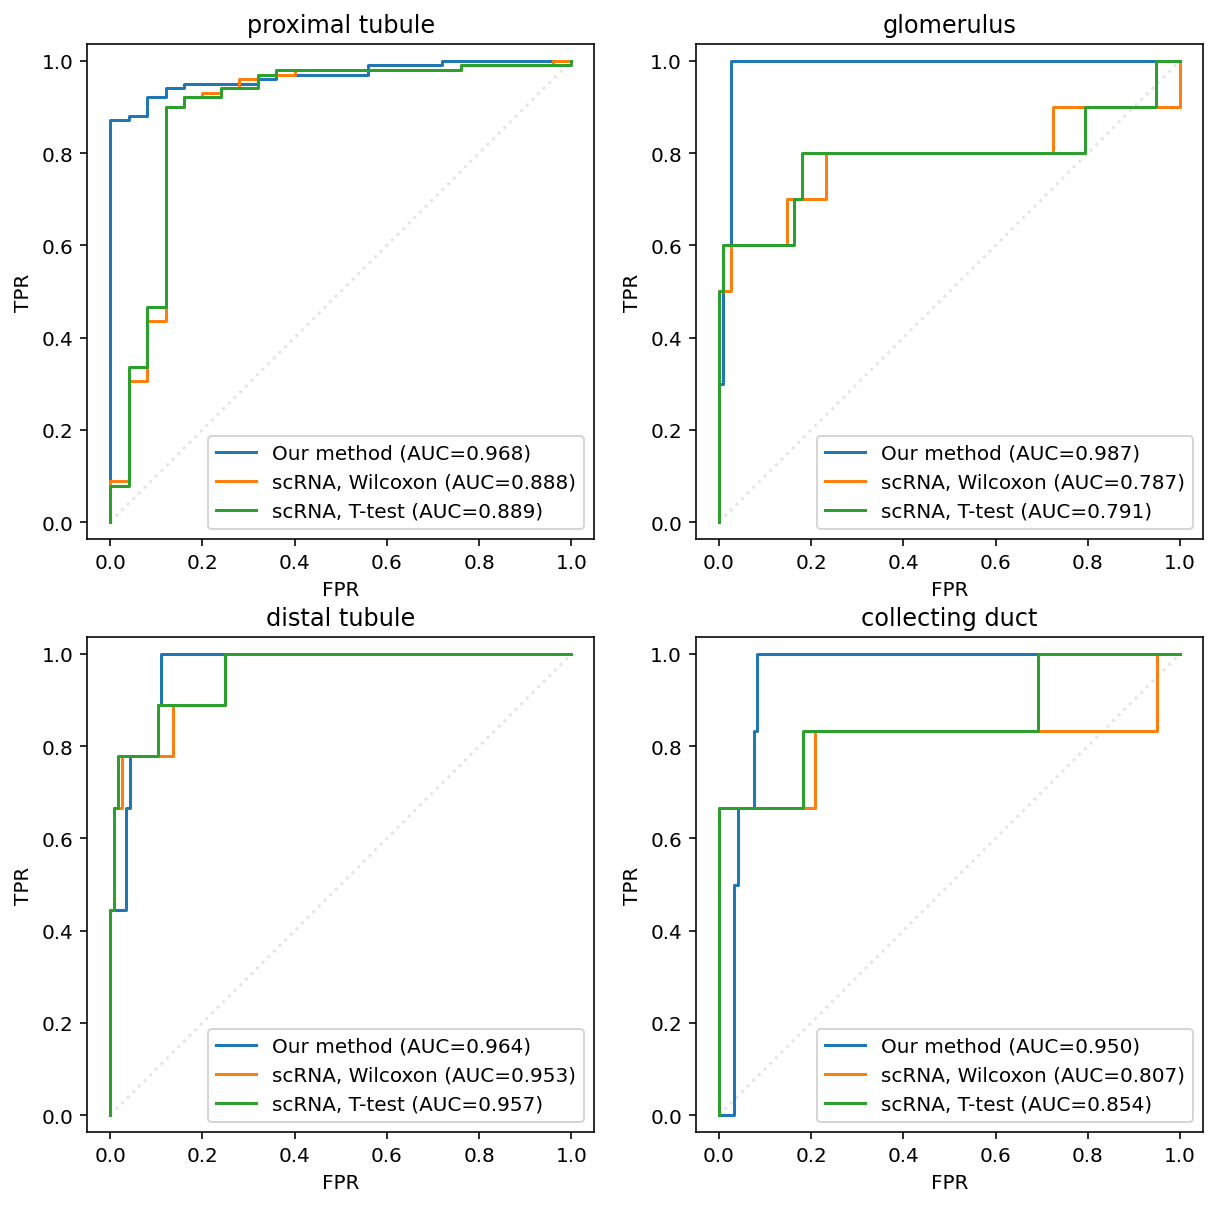

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

regions = true_regions.sum().sort_values(ascending=False).index.tolist()

def plot_roc(region_scores, ax, name, **kwargs):
    y = true_regions[region]
    y_pred = region_scores[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} (AUC=%.3f)'%auc, **kwargs)

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    plot_roc(simclr_regions, ax, 'Our method')
    plot_roc(wilcoxon_regions, ax, 'scRNA, Wilcoxon')
    plot_roc(ttest_regions, ax, 'scRNA, T-test')
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()

plt.savefig('./figures/roc.png', dpi=300)